# **Análisis de Churn de Clientes**

Este proyecto aborda el desafío de identificar los factores que influyen en la cancelación de servicios por parte de los clientes. Utiliza datos reales extraídos desde una API en formato JSON, aplicando técnicas de ETL para su transformación y análisis. A través de visualizaciones estratégicas y un análisis exploratorio profundo, se generan insights clave para mejorar la retención de clientes.

## 1. Configuración del Entorno
Primero, importamos las librerías necesarias para el análisis y la visualización de datos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

## 2. Carga y Transformación Inicial de Datos
En este paso, cargamos los datos desde el archivo JSON y los transformamos en un DataFrame de Pandas. La estructura del JSON es anidada, por lo que utilizaremos pd.json_normalize para aplanarla y facilitar su manipulación.

In [5]:
# Cargar el archivo JSON
file_path = 'data/TelecomX_Data.json'
with open(file_path, 'r') as f:
    data = json.load(f)

# Verificar la estructura del JSON para asegurar el aplanamiento correcto
if isinstance(data, dict) and 'customers' in data:
    customers = data['customers']
else:
    customers = data

# Aplanar todos los campos anidados en un solo DataFrame
df = pd.json_normalize(customers, sep='.')

# Renombrar columnas para mayor claridad
df = df.rename(columns={
    'customerID': 'customerID',
    'Churn': 'Churn',
    'customer.gender': 'Gender',
    'customer.SeniorCitizen': 'SeniorCitizen',
    'customer.Partner': 'Partner',
    'customer.Dependents': 'Dependents',
    'customer.tenure': 'Tenure',
    'phone.PhoneService': 'PhoneService',
    'phone.MultipleLines': 'MultipleLines',
    'internet.InternetService': 'InternetService',
    'internet.OnlineSecurity': 'OnlineSecurity',
    'internet.OnlineBackup': 'OnlineBackup',
    'internet.DeviceProtection': 'DeviceProtection',
    'internet.TechSupport': 'TechSupport',
    'internet.StreamingTV': 'StreamingTV',
    'internet.StreamingMovies': 'StreamingMovies',
    'account.Contract': 'Contract',
    'account.PaperlessBilling': 'PaperlessBilling',
    'account.PaymentMethod': 'PaymentMethod',
    'account.Charges.Monthly': 'MonthlyCharges',
    'account.Charges.Total': 'TotalCharges'
})

print("Datos cargados y transformados con éxito.")

Datos cargados y transformados con éxito.


## 3. Exploración Inicial y Verificación de Datos
Ahora, exploraremos el DataFrame para entender su estructura, los tipos de datos y si existen problemas evidentes como valores nulos o formatos incorrectos.

In [6]:
# Mostrar las primeras 5 filas para tener una vista previa
print("Vista previa de los datos:")
print(df.head())

# Obtener información general del DataFrame, incluyendo tipos de datos y valores no nulos
print("\nInformación general del DataFrame:")
df.info()

# Revisar si hay valores duplicados
print(f"\nNúmero de filas duplicadas: {df.duplicated().sum()}")

# La columna 'TotalCharges' se cargó como 'object'. Es un problema común que debemos corregir.
# Vamos a investigar por qué.
# Intentaremos convertirla a numérico, y los valores que fallen se marcarán como NaT (Not a Time) o NaN (Not a Number).
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Ahora, contemos cuántos valores nulos hay en 'TotalCharges' después de la conversión.
print(f"\nValores nulos en 'TotalCharges' después de la conversión: {df['TotalCharges'].isnull().sum()}")

# Veamos las filas donde 'TotalCharges' es nulo para entender la causa.
print("\nFilas con 'TotalCharges' nulos:")
print(df[df['TotalCharges'].isnull()][['Tenure', 'MonthlyCharges', 'TotalCharges']])

Vista previa de los datos:
   customerID Churn  Gender  SeniorCitizen Partner Dependents  Tenure  \
0  0002-ORFBO    No  Female              0     Yes        Yes       9   
1  0003-MKNFE    No    Male              0      No         No       9   
2  0004-TLHLJ   Yes    Male              0      No         No       4   
3  0011-IGKFF   Yes    Male              1     Yes         No      13   
4  0013-EXCHZ   Yes  Female              1     Yes         No       3   

  PhoneService MultipleLines InternetService  ... OnlineBackup  \
0          Yes            No             DSL  ...          Yes   
1          Yes           Yes             DSL  ...           No   
2          Yes            No     Fiber optic  ...           No   
3          Yes            No     Fiber optic  ...          Yes   
4          Yes            No     Fiber optic  ...           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No         Yes         Yes              No 

**Observación Clave**: El análisis revela que los 11 valores nulos en TotalCharges corresponden a clientes con una antigüedad (Tenure) de 0. Esto es lógico, ya que son clientes nuevos que aún no han acumulado cargos totales.

## 4. Limpieza y Corrección de Datos
Con los problemas identificados, procedemos a limpiar el DataFrame. Corregiremos los valores nulos en TotalCharges y nos aseguraremos de que todos los tipos de datos sean correctos.

In [7]:
# Rellenamos los valores nulos en 'TotalCharges' con 0.
# Esto es apropiado porque los clientes con 0 meses de antigüedad no han generado cargos totales.
df['TotalCharges'].fillna(0, inplace=True)

# Verificamos que ya no hay valores nulos en la columna
print(f"Valores nulos restantes en 'TotalCharges': {df['TotalCharges'].isnull().sum()}")

# Ahora la columna 'SeniorCitizen' es numérica (0 o 1) pero representa una categoría.
# La convertiremos a un formato más claro ('No'/'Sí') para mejorar la legibilidad en las visualizaciones.
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

print("\nLimpieza de datos completada.")

Valores nulos restantes en 'TotalCharges': 0

Limpieza de datos completada.


C:\Users\apicn\AppData\Local\Temp\ipykernel_39452\3163623213.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


## 5. Ingeniería de Características (Feature Engineering)
Para enriquecer nuestro análisis, crearemos una nueva columna llamada Cuentas_Diarias. Esta métrica nos dará una perspectiva más granular de los gastos del cliente.

In [8]:
# Asumimos un mes de 30 días para el cálculo.
df['DailyCharges'] = df['MonthlyCharges'] / 30

print("Columna 'DailyCharges' creada con éxito.")
print(df[['MonthlyCharges', 'DailyCharges']].head())

Columna 'DailyCharges' creada con éxito.
   MonthlyCharges  DailyCharges
0            65.6      2.186667
1            59.9      1.996667
2            73.9      2.463333
3            98.0      3.266667
4            83.9      2.796667


## 6. Estandarización y Transformación de Datos

In [9]:
# Convertimos la variable objetivo 'Churn' a formato numérico (0/1)
df['Churn_numeric'] = df['Churn'].map({'No': 0, 'Yes': 1})

# También crearemos una copia del DataFrame para transformar más columnas
# sin afectar el original, que usaremos para visualizaciones.
df_transformed = df.copy()

# Columnas binarias a transformar
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for col in binary_cols:
    df_transformed[col] = df_transformed[col].map({'No': 0, 'Yes': 1})

print("Transformación de datos a formato numérico completada.")
print(df_transformed[['Churn', 'Churn_numeric']].head())

Transformación de datos a formato numérico completada.
  Churn  Churn_numeric
0    No            0.0
1    No            0.0
2   Yes            1.0
3   Yes            1.0
4   Yes            1.0


## 7. Análisis Descriptivo
Calculamos estadísticas descriptivas para las variables numéricas. Esto nos ayuda a entender la distribución, la tendencia central y la dispersión de los datos.

In [10]:
# Estadísticas para las principales columnas numéricas
print("Análisis descriptivo de las variables numéricas:")
print(df[['Tenure', 'MonthlyCharges', 'TotalCharges', 'DailyCharges']].describe())

Análisis descriptivo de las variables numéricas:
            Tenure  MonthlyCharges  TotalCharges  DailyCharges
count  7267.000000     7267.000000   7267.000000   7267.000000
mean     32.346498       64.720098   2277.182035      2.157337
std      24.571773       30.129572   2268.648587      1.004319
min       0.000000       18.250000      0.000000      0.608333
25%       9.000000       35.425000    396.200000      1.180833
50%      29.000000       70.300000   1389.200000      2.343333
75%      55.000000       89.875000   3778.525000      2.995833
max      72.000000      118.750000   8684.800000      3.958333


## 8. Análisis Exploratorio de Datos (EDA) y Visualizaciones
Esta es la fase más visual del proyecto. Generaremos gráficos para explorar la relación entre las diferentes variables y la tasa de cancelación (Churn).

#### 8.1. Distribución del Churn
Visualizamos la proporción de clientes que han cancelado el servicio frente a los que no.

C:\Users\apicn\AppData\Local\Temp\ipykernel_39452\1412259754.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Churn', order=['No', 'Yes'], palette=colors, edgecolor='black')


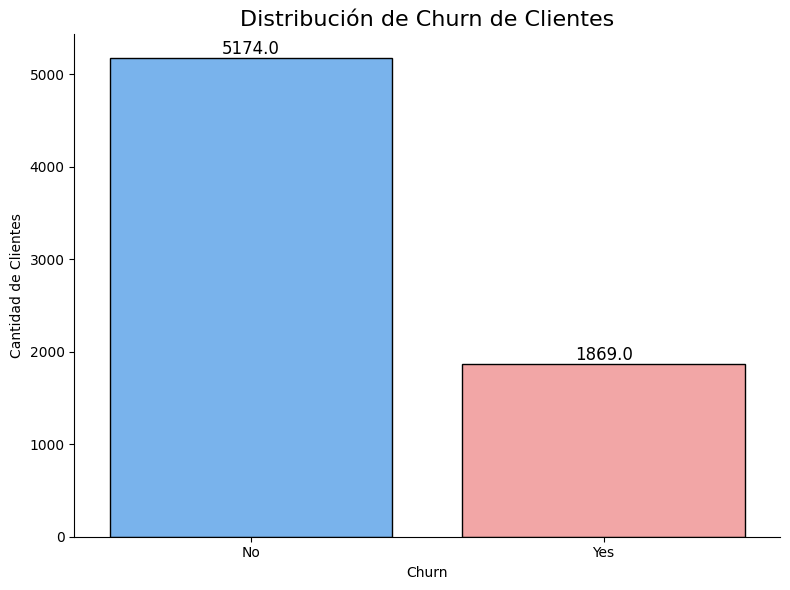

In [14]:
plt.figure(figsize=(8, 6))
colors = ['#66b3ff', '#ff9999']
ax = sns.countplot(data=df, x='Churn', order=['No', 'Yes'], palette=colors, edgecolor='black')
plt.title('Distribución de Churn de Clientes', fontsize=16)
plt.xlabel('Churn')
plt.ylabel('Cantidad de Clientes')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=12, color='black')
sns.despine()
plt.tight_layout()
plt.savefig('churn_distribution_bar.png')
plt.show()

**Insight**: La mayoría de los clientes (aproximadamente 3 de cada 4) permanecen con la compañía, pero una cuarta parte representa una tasa de cancelación significativa que merece ser investigada.

#### 8.2. Churn por Variables Categóricas
Analizamos cómo la cancelación varía según el tipo de contrato, método de pago y otros factores.

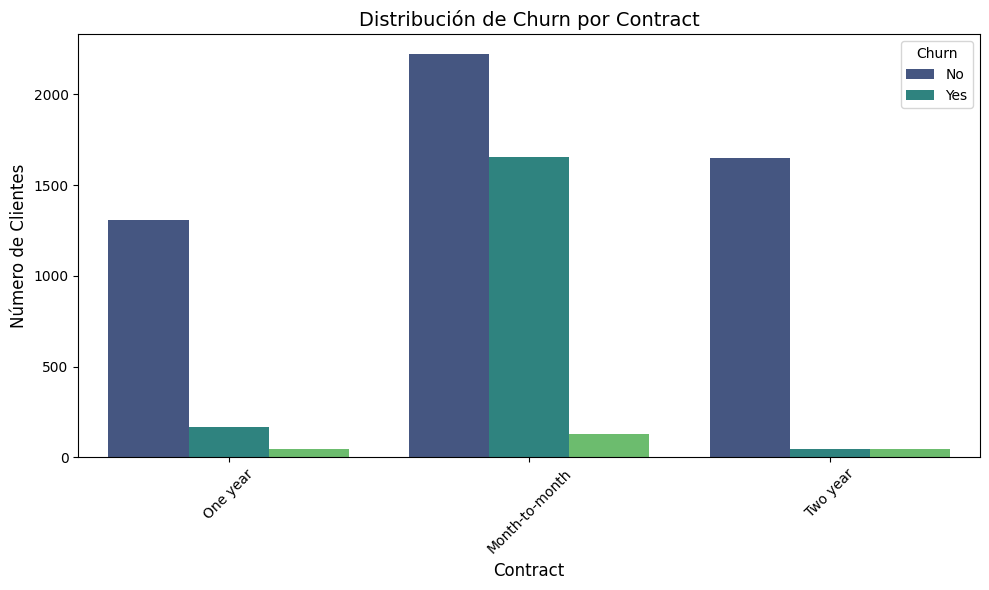

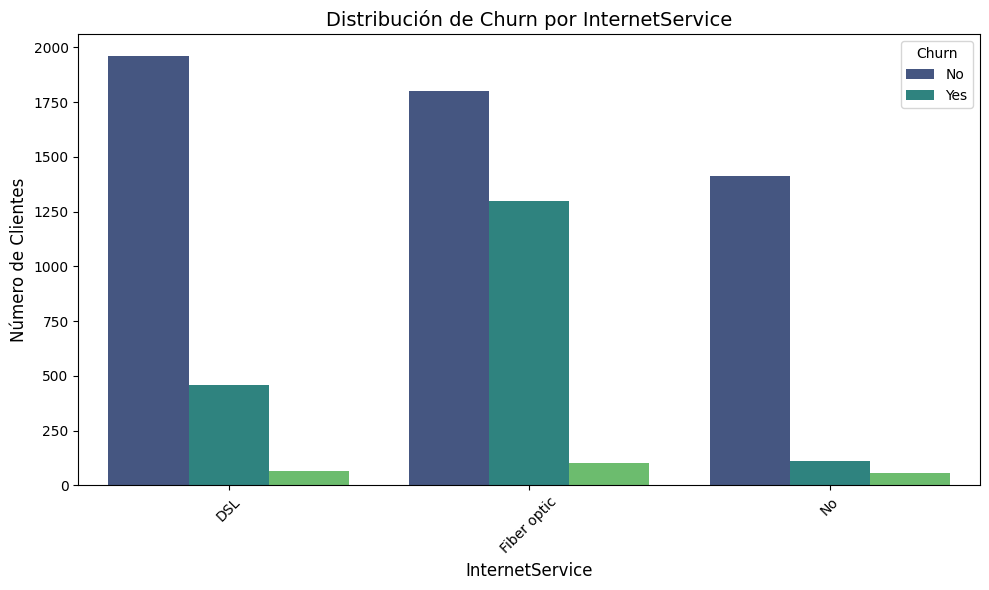

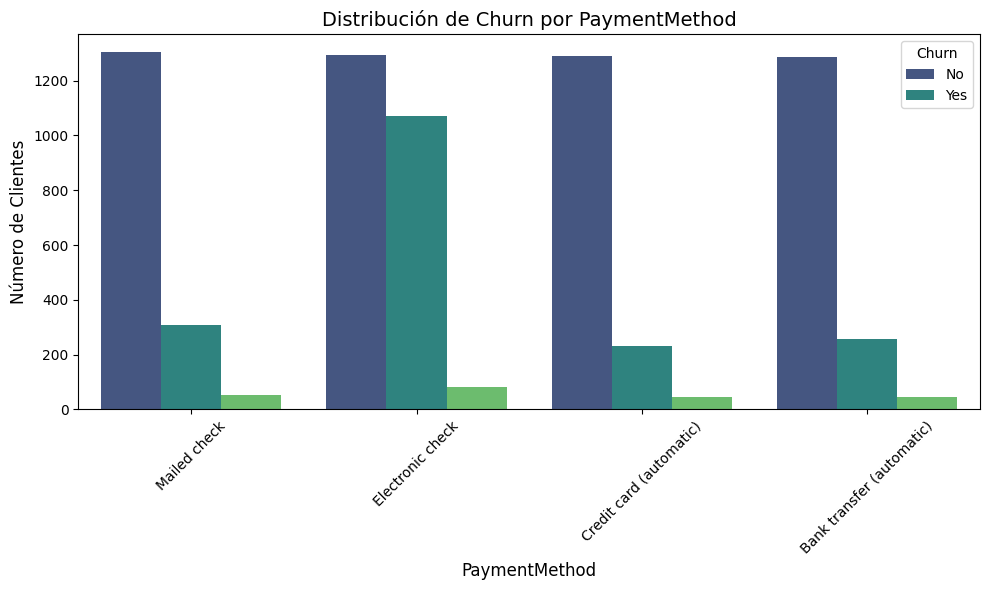

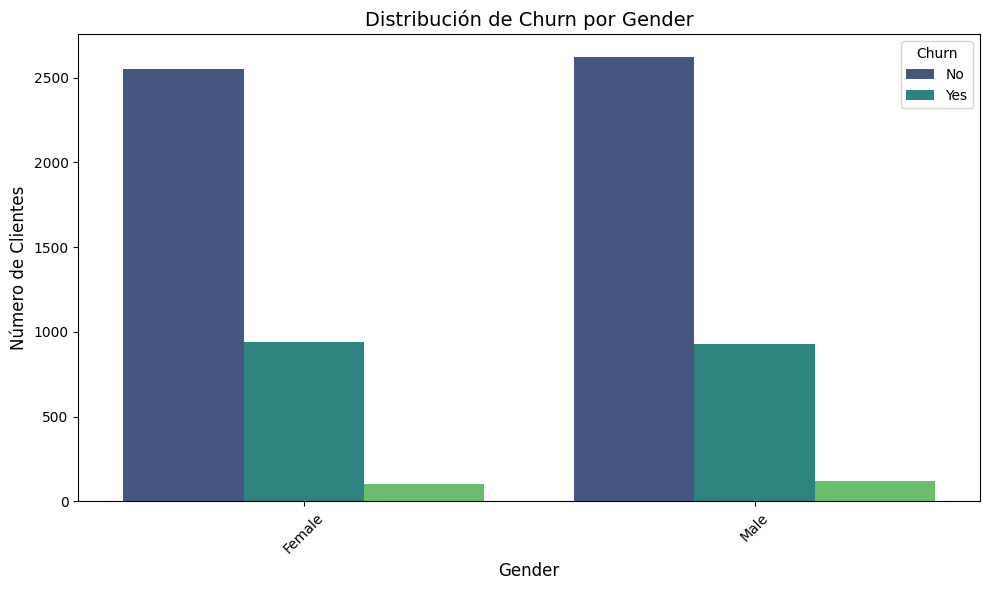

In [15]:
# Seleccionamos las variables categóricas más relevantes
categorical_features = ['Contract', 'InternetService', 'PaymentMethod', 'Gender']

# Creamos un gráfico para cada variable
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=feature, hue='Churn', palette='viridis')
    plt.title(f'Distribución de Churn por {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Número de Clientes', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Churn')
    plt.tight_layout()
    plt.savefig(f'churn_by_{feature}.png')
    plt.show()

**Insights Clave**:

- Contrato: Los clientes con contratos mes a mes tienen una tasa de cancelación drásticamente mayor que aquellos con contratos anuales o de dos años. Esto sugiere que la falta de un compromiso a largo plazo es un factor de riesgo importante.

- Servicio de Internet: Los clientes con Fibra Óptica tienden a cancelar más que los que tienen DSL. Esto podría deberse a problemas de precio, calidad del servicio o expectativas no cumplidas.

- Método de Pago: Los clientes que pagan con cheque electrónico muestran una tasa de churn mucho más alta. Esto podría indicar problemas de facturación o una menor lealtad del cliente.

#### 8.3. Churn por Variables Numéricas
Comparamos la distribución de antigüedad, cargos mensuales y totales entre los clientes que cancelaron y los que no.

C:\Users\apicn\AppData\Local\Temp\ipykernel_39452\2601015992.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y=feature, palette='coolwarm')


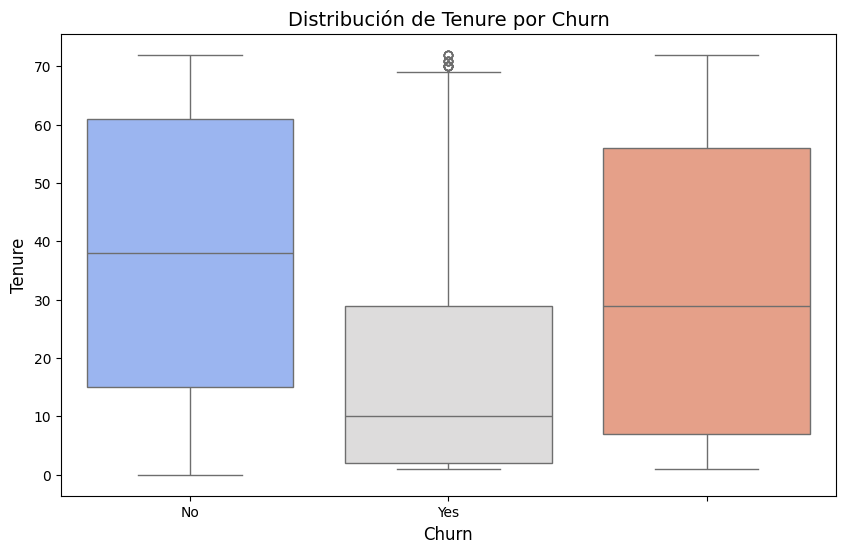

C:\Users\apicn\AppData\Local\Temp\ipykernel_39452\2601015992.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y=feature, palette='coolwarm')


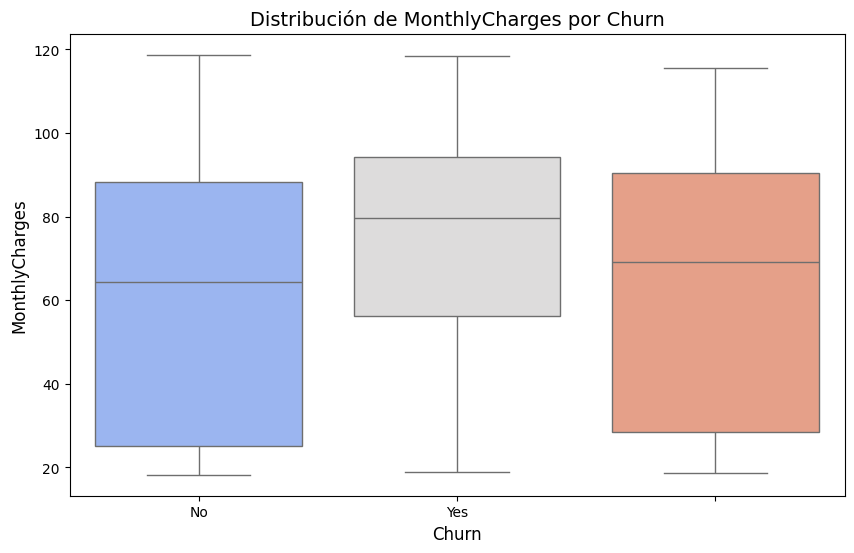

C:\Users\apicn\AppData\Local\Temp\ipykernel_39452\2601015992.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y=feature, palette='coolwarm')


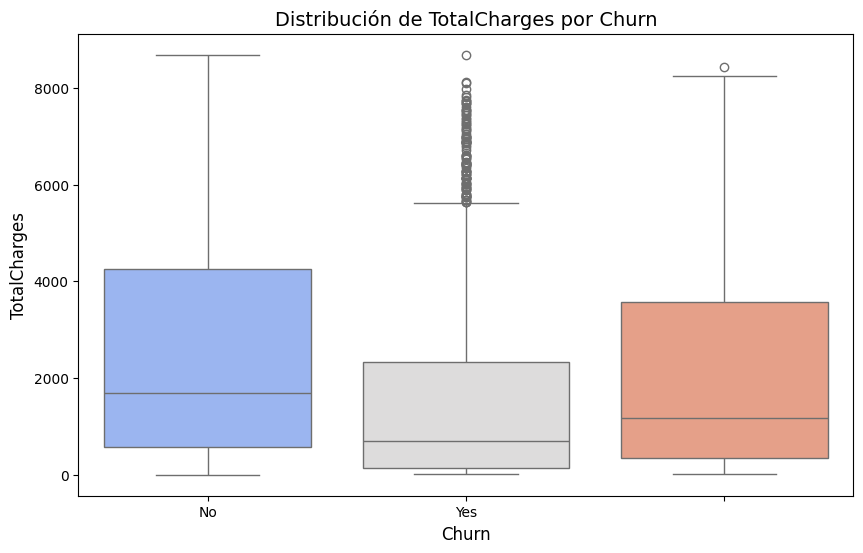

In [16]:
numerical_features = ['Tenure', 'MonthlyCharges', 'TotalCharges']

for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Churn', y=feature, palette='coolwarm')
    plt.title(f'Distribución de {feature} por Churn', fontsize=14)
    plt.xlabel('Churn', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.savefig(f'churn_by_numeric_{feature}.png')
    plt.show()

**Insights Clave**:

- Antigüedad (Tenure): Los clientes que cancelan tienden a tener una antigüedad mucho menor. Esto confirma que los clientes más nuevos son los más propensos a irse.

- Cargos Mensuales (MonthlyCharges): Los clientes que cancelan suelen tener cargos mensuales más altos. El precio parece ser un factor decisivo.

- Cargos Totales (TotalCharges): Curiosamente, los clientes que cancelan tienen cargos totales más bajos, lo cual es un reflejo directo de su corta antigüedad en la compañía.